# NLP with Disaster Tweets

In [46]:
# Datos proporcionados para el carbono-14
semivida_C14_anos = 5730  # Semivida del carbono-14 en años
actividad_vivo = 2 * 10**5  # Actividad en organismos vivos por gramo (desintegraciones/minuto)
actividad_manuscrito = 1.5 * 10**5  # Actividad en el manuscrito por gramo (desintegraciones/minuto)
masa_manuscrito_g = 4  # Masa de la muestra de carbono en el manuscrito (gramos)

# Ajuste de la actividad inicial para la misma cantidad de carbono en el manuscrito
A0_manuscrito = actividad_vivo * masa_manuscrito_g  # Actividad inicial para 4 g de carbono

# Cálculo de la edad del manuscrito
# A/A0 = (1/2)^(t/T1/2)
A_A0_manuscrito = (actividad_manuscrito ) / A0_manuscrito
t_manuscrito = semivida_C14_anos * math.log(A_A0_manuscrito) / math.log(1/2)

t_manuscrito


13838.164870867775

In [43]:
A0_131I, N0_131I

(138296898899093.19, 1.3790839694656487e+20)

In [1]:
#Import libraries and set configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from collections import Counter
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
from textblob import TextBlob

import warnings


pd.options.display.max_rows = 400
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## 1. Load and Preliminary Examination

In [2]:
# Load data
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

In [3]:
def missing_data(df):
    total_missing = df.isnull().sum()
    percentage_missing = round((df.isnull().sum() / df.shape[0]) * 100,2)

    missing_data = pd.DataFrame({'Total Missing': total_missing, 'Percentage (%)': percentage_missing})
    missing_data = missing_data.sort_values(by='Total Missing', ascending=False)

    return missing_data

print("Train Dataset Information:")
display(train_df.head())
display(train_df.info())
print("Missing values: ")
display(missing_data(train_df))

Train Dataset Information:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

Missing values: 


,Total Missing,Percentage (%)
location,2533,33.27
keyword,61,0.80
id,0,0.00
text,0,0.00
target,0,0.00


In [4]:
print("Test Dataset Information:")
display(test_df.head())
display(test_df.info())
print("Missing values: ")
display(missing_data(test_df))

Test Dataset Information:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

Missing values: 


,Total Missing,Percentage (%)
location,1105,33.86
keyword,26,0.80
id,0,0.00
text,0,0.00


In [5]:
train_df['target'] = train_df['target'].astype(str) 

## EDA Raw Data

In [6]:
# Creamos copias de los datos originales
train_df1 = train_df.copy()
test_df1 = test_df.copy()

### Target Analysis

In [7]:
# Calcula la proporción y convierte a porcentaje, luego redondea
target_distribution = (train_df1['target'].value_counts(normalize=True) * 100).round(2)

print("Target 0 la proporcion es", target_distribution[0], "%")
print("Target 1 la proporcion es", target_distribution[1], "%")

Target 0 la proporcion es 57.03 %
Target 1 la proporcion es 42.97 %


### Keyword Analysis

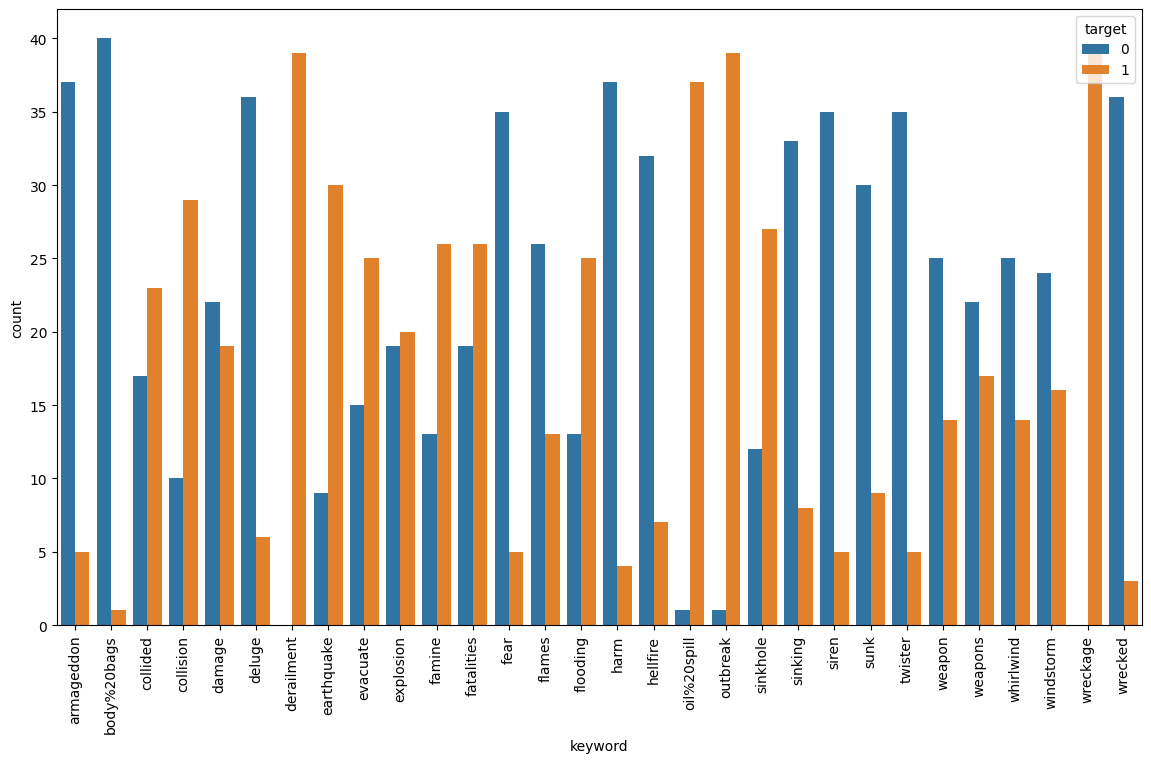

In [8]:
frecuent_keyword = train_df1[train_df1['keyword'].isin(train_df1['keyword'].value_counts().head(30).index)]
plt.figure(figsize=(14,8))
sns.countplot(data= frecuent_keyword, x= 'keyword', hue= 'target')
plt.xticks(rotation=90)
plt.show()

A partir del grafico anterior podemos obtener las keyword mas frecuentes que aparecen en tweets clasificados como sisaster o no disaster. 
-  Las keyword mas frecuentes en tweet disaster son: collison, derailment, evacuate, earthquake, famine, flooding,oil%20spill, outbreak, sinkhole, wreckage.
- Las keyword mas frecuentes en teets que no disaster son: armaggdeddon, body%20bags, deluge, fear, flames, harm, helfire, sniking, siren, sunk, twister, wrecked.

In [9]:
def top_feature_full_comparison(train_df, test_df, feature, top_n=40):
    # Calcula las top_n palabras clave más frecuentes en train_df
    top_values_train = train_df[feature].value_counts().head(top_n).index.tolist()
    
    # Filtra el train_df para las top_n palabras clave
    filtered_train_df = train_df[train_df[feature].isin(top_values_train)]
    
    # Crea un DataFrame con las cuentas para target = 1 y target = 0
    feature_target_counts = filtered_train_df.groupby([feature, 'target']).size().unstack(fill_value=0)
    feature_target_counts.columns = ['count_target_0', 'count_target_1']
    
    # Resetea el índice para que feature sea una columna
    feature_target_counts.reset_index(inplace=True)
    
    # Combina las frecuencias de train y test en un único DataFrame
    combined_df = feature_target_counts.merge(
        train_df[feature].value_counts().rename('frequency_train'),
        left_on=feature,
        right_index=True
    ).merge(
        test_df[feature].value_counts().rename('frequency_test'),
        left_on=feature,
        right_index=True,
        how='left'
    )
    combined_df['% target_0'] = round(100*combined_df['count_target_0']/combined_df['frequency_train'],2)
    combined_df['% target_1'] = round(100*combined_df['count_target_1']/ combined_df['frequency_train'],2)
    combined_df = combined_df[[feature, 'frequency_test', 'frequency_train',
                                                 'count_target_0','count_target_1','% target_0','% target_1']]
    # Ordena el DataFrame resultante por la frecuencia en el conjunto de entrenamiento de forma descendente
    combined_df.sort_values('frequency_train', ascending=False, inplace=True)
    
    return combined_df.head(top_n)


In [10]:
top_feature_full_comparison(train_df1,test_df1, 'keyword')

,keyword,frequency_test,frequency_train,count_target_0,count_target_1,% target_0,% target_1
18,fatalities,5,45,19,26,42.22,57.78
8,deluge,8,42,36,6,85.71,14.29
1,armageddon,8,42,37,5,88.10,11.90
23,harm,9,41,37,4,90.24,9.76
28,sinking,9,41,33,8,80.49,19.51
3,body%20bags,9,41,40,1,97.56,2.44
6,damage,9,41,22,19,53.66,46.34
13,evacuate,10,40,15,25,37.50,62.50
32,twister,10,40,35,5,87.50,12.50
29,siren,10,40,35,5,87.50,12.50


### Location Analysis

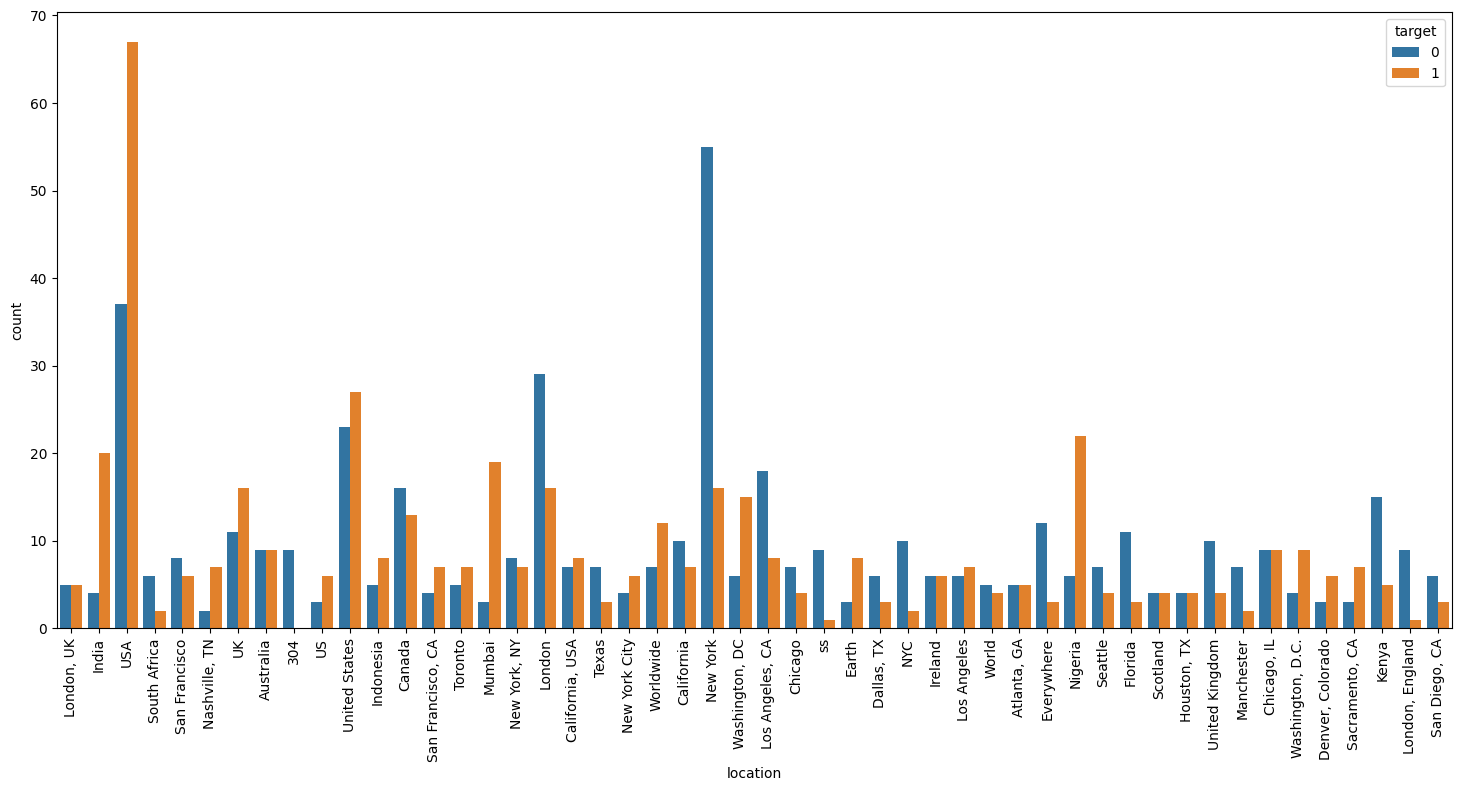

In [11]:
plt.figure(figsize=(18,8))
frecuent_location = train_df1['location'].value_counts().head(50).index
frecuent_location_df = train_df1[train_df1['location'].isin(frecuent_location)]
sns.countplot(data=frecuent_location_df, x = 'location' , hue = 'target')
plt.xticks(rotation=90)
plt.show()

In [12]:
top = top_feature_full_comparison(train_df1,test_df1,'location',400).sort_values('location', ascending=True)
top

,location,frequency_test,frequency_train,count_target_0,count_target_1,% target_0,% target_1
0,Road to the Billionaires Club,4.0,6,5,1,83.33,16.67
1,#FLIGHTCITY UK,NaN,3,3,0,100.00,0.00
2,107-18 79TH STREET,NaN,2,2,0,100.00,0.00
3,"19.600858, -99.047821",NaN,2,0,2,0.00,100.00
4,"21.462446,-158.022017",NaN,3,1,2,33.33,66.67
5,304,2.0,9,9,0,100.00,0.00
6,?,NaN,4,3,1,75.00,25.00
7,??,1.0,4,2,2,50.00,50.00
8,???,NaN,3,1,2,33.33,66.67
9,??? Dreamz,NaN,2,2,0,100.00,0.00


In [13]:
def normalize_location(location):
    # Verificar si 'location' es una cadena de texto
    if isinstance(location, str):
        # Eliminar puntos y convertir a minúsculas
        location = location.replace('.', '').lower().strip()

        # Comprobar si la ubicación contiene solo letras, espacios y comas
        if re.match("^[A-Za-z ,]*$", location):
            # Dividir la localización en partes basadas en comas
            parts = location.split(',')

            # Manejar según la cantidad de comas
            if len(parts) == 2:  # Si hay una coma, toma la parte antes de la coma
                location = parts[0].strip()
            elif len(parts) > 2:  # Si hay más de dos comas, usa toda la localización
                location = ' '.join(parts).replace(',', '').strip()
            else:  # Si no hay comas, procede normalmente
                words = location.split()
                if len(words) > 1 and len(words[-1]) < 4:
                    return ' '.join(words[:-1])  # Devuelve todas las palabras excepto la última
                elif len(words) >= 1:
                    return ' '.join(words[:])
            return location
        else:
            return ""
    else:
        # Devolver un valor predeterminado (por ejemplo, una cadena vacía) si 'location' no es una cadena de texto
        return ""

# Aplicar la función de normalización a la columna 'location'
train_df1['normalized_location'] = train_df1['location'].apply(normalize_location)
test_df1['normalized_location'] = test_df1['location'].apply(normalize_location)

In [14]:

location_mapping = {
    'usa': 'united states',
    'us': 'united states',
    'ny': 'new york',
    'nyc': 'new york',
    'new york city': 'new york',
    'atlanta georgia' : 'atlanta',
    'brasil': 'brazil',
    'ca': 'california',
    'ca via brum' : 'california',
    'dc': 'washington',
    'karachi pakistan' : 'karachi',
    'uk': 'united kingdom',
    'england': 'United Kingdom', 
    'lagos nigeria' : 'lagos',
    "jakarta/kuala lumpur/s'pore" : 'jakarta',
    'san francisco bay area' : 'san francisco',
    'ma' : 'massachusetts',
    'melbourne australia' : 'melbourne',
    'nairobi-kenya' : 'nairobi',
    'nj': 'new jersey',
    'sydney australia' : 'sydney',
    'tx' : 'texas',
    'ontario canada' : 'ontario', 
    'washington state' : 'washington',
    'world wide' : 'worldwide',
    'world' : 'worldwide',
    'global' : 'worldwide', 
    'global-nolocation' : 'worldwide',
    'planet earth': 'worldwide',
    'everywhere' : 'worldwide',
    'earth' : 'worldwide',
    'in the word of' : 'worldwide',
    'anonymous' : '',
    'buenos aires argentina': 'buenos aires'
    
}


In [15]:
train_df1['location_final'] = train_df1['normalized_location'].replace(location_mapping)
test_df1['location_final'] = test_df1['normalized_location'].replace(location_mapping)


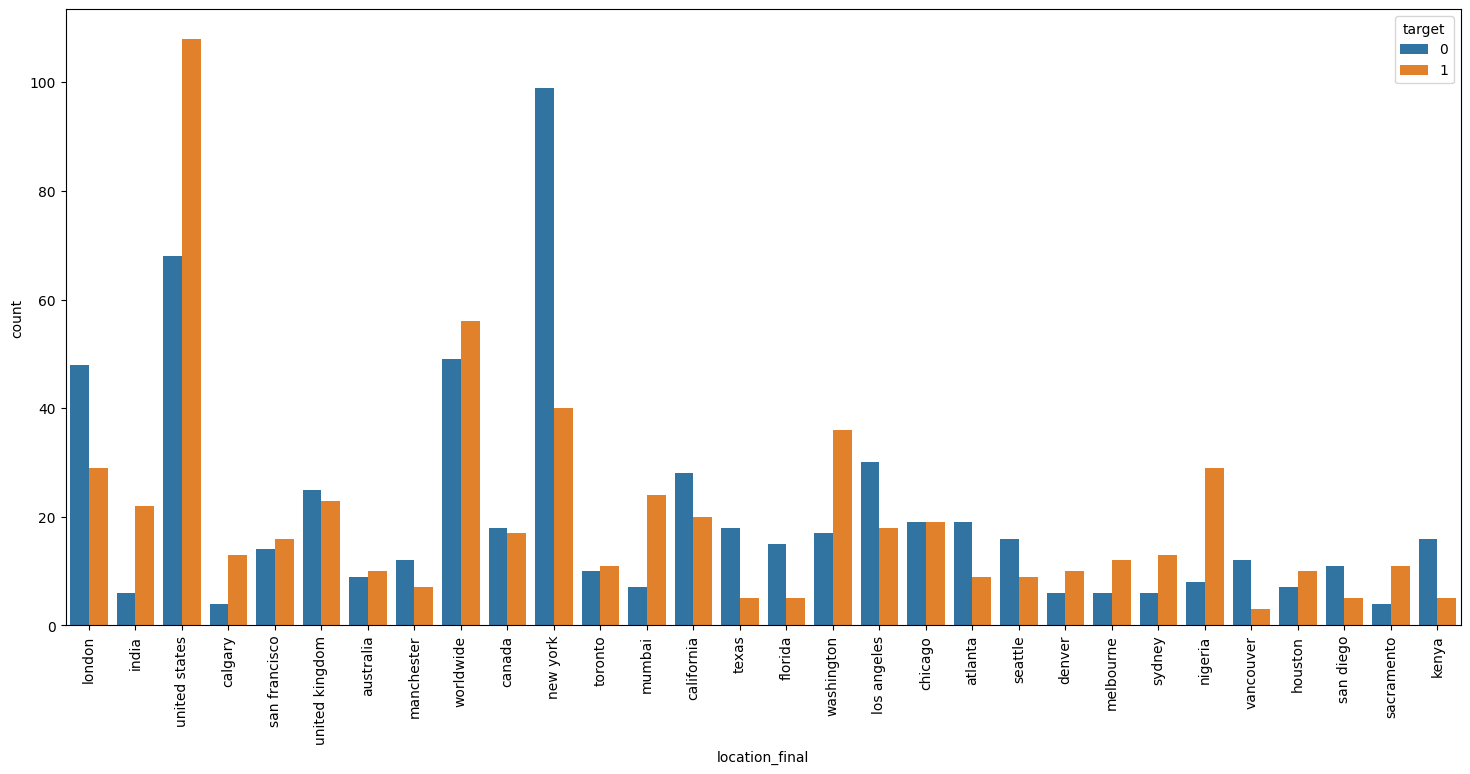

In [16]:
plt.figure(figsize=(18,8))
frecuent_location = train_df1[train_df1['location_final'] != '']['location_final'].value_counts().head(30).index
frecuent_location_df = train_df1[train_df1['location_final'].isin(frecuent_location)]
sns.countplot(data=frecuent_location_df, x = 'location_final' , hue = 'target')
plt.xticks(rotation=90)
plt.show()

### Text Analysis

In [17]:
# Create column for lenght of the text
train_df1['tweet_length'] = train_df['text'].apply(len)
test_df1['tweet_length'] = test_df['text'].apply(len)
print("Summary Length text Train data:\n", train_df1['tweet_length'].describe())
print("\nSummary Length text Test data:\n", test_df1['tweet_length'].describe())

Summary Length text Train data:
 count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: tweet_length, dtype: float64

Summary Length text Test data:
 count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: tweet_length, dtype: float64


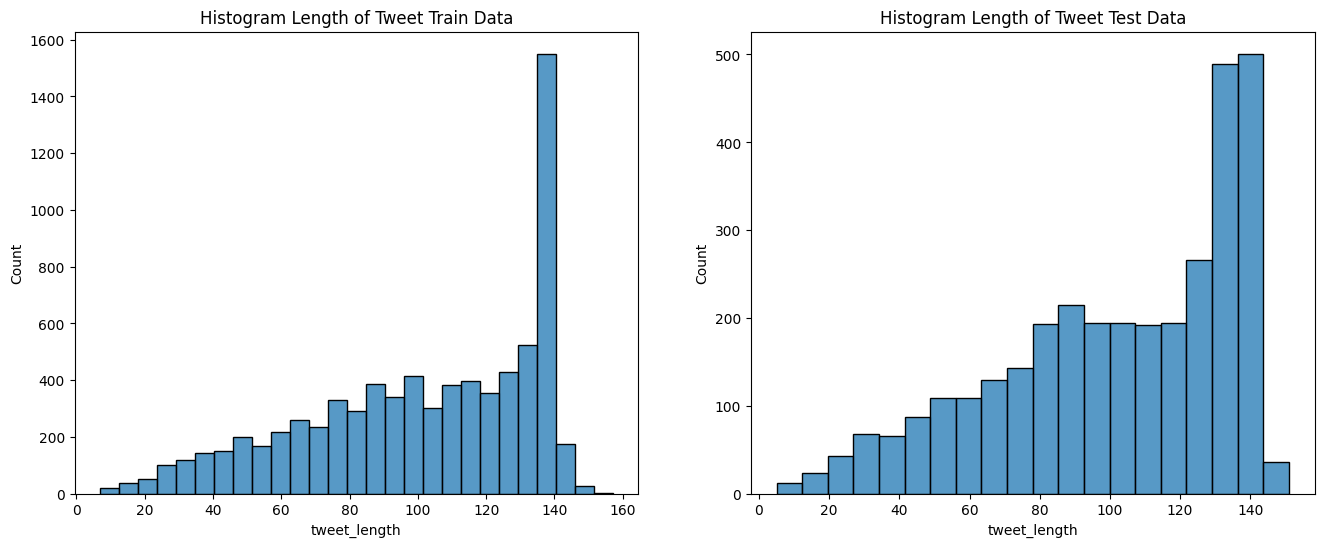

In [18]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
plt.title("Histogram Length of Tweet Train Data")
sns.histplot(data=train_df1, x= 'tweet_length')


plt.subplot(1,2,2)
plt.title("Histogram Length of Tweet Test Data")
sns.histplot(data=test_df1, x= 'tweet_length')

plt.show()

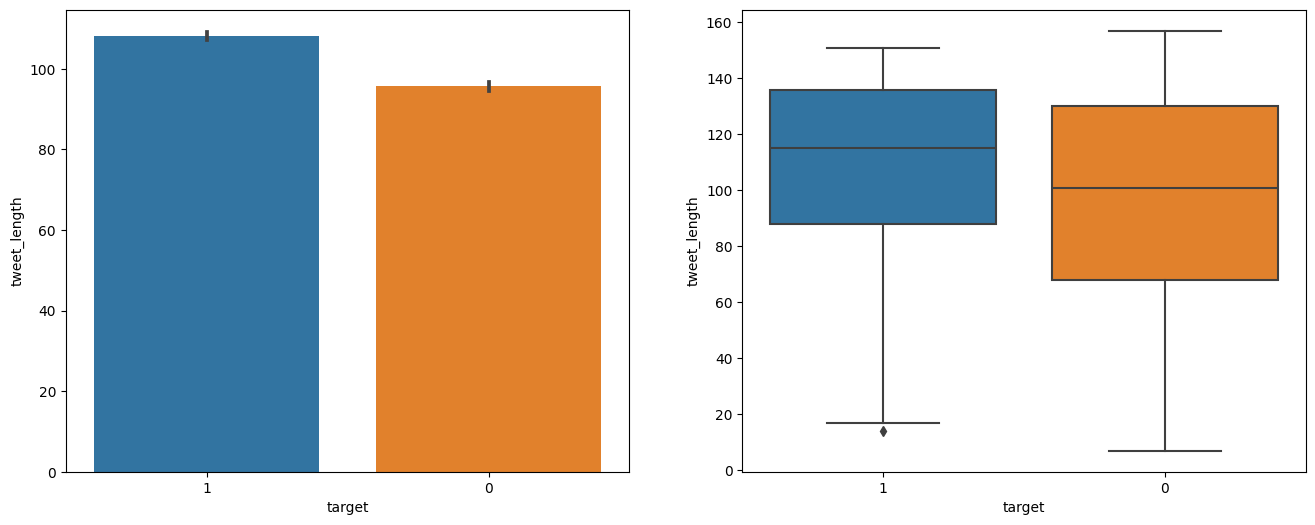

In [19]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.barplot(data=train_df1, x='target', y='tweet_length')

plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='target', y='tweet_length')
plt.show()

In [20]:
# Función para limpiar el texto
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Remueve URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remueve caracteres especiales y números
    text = re.sub(r'\W', ' ', text)
    # Remueve caracteres individuales
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remueve múltiples espacios
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Función para verificar la presencia de números
def contains_numbers(text):
    return 1 if any(char.isdigit() for char in text) else 0

# Función para verificar la presencia de caracteres especiales
def contains_special_characters(text):
    return any(not char.isalnum() for char in text)

# Función para contar palabras en mayúsculas
def count_uppercase_words(text):
    return sum(1 for word in text.split() if word.isupper())

def detect_repeated_vowels(text):
    # Expresión regular para detectar tres o más vocales seguidas
    pattern = r'[aeiou]{3,}'
    
    # Buscar todas las ocurrencias de la expresión regular en el texto
    matches = re.findall(pattern, text.lower())
    
    # Devuelve True si se encuentra alguna coincidencia, False de lo contrario
    return 1 if bool(matches) else 0



# Aplicar las funciones al DataFrame
train_df1['clean_text'] = train_df1['text'].apply(clean_text)
train_df1['words'] = train_df1['clean_text'].apply(lambda x: x.split())
train_df1['word_count'] = train_df1['words'].apply(len)
train_df1['contains_numbers'] = train_df1['text'].apply(contains_numbers)
train_df1['hashtag_count'] = train_df1['text'].apply(lambda x: x.count('#'))
train_df1['mention_count'] = train_df1['text'].apply(lambda x: x.count('@'))
train_df1['exclamation_mark_count'] = train_df1['text'].apply(lambda x: x.count('!'))
train_df1['question_mark_count'] = train_df1['text'].apply(lambda x: x.count('?'))
train_df1['url_count'] = train_df1['text'].apply(lambda x: len(re.findall(r'http\S+|www\S+', x)))
train_df1['uppercase_word_count'] = train_df1['text'].apply(count_uppercase_words)
train_df1['sentiment'] = train_df1['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df1['repeated_vowels'] = train_df1['text'].apply(detect_repeated_vowels)


In [21]:
# Función para limpiar y tokenizar el texto
def clean_and_tokenize(text):
    tokens = word_tokenize(text.lower())  # Convertir a minúsculas y tokenizar
    tokens = [word for word in tokens if word.isalpha() and len(word) > 4]  # Quitar signos de puntuación
    return tokens

# Aplicar la función a cada tweet
tokenized_tweets = train_df1['text'].apply(clean_and_tokenize)
# Contar la frecuencia de cada palabra
word_freq = Counter(token for tokens in tokenized_tweets for token in tokens)

# Las 20 palabras más comunes
most_common_words = word_freq.most_common(30)
most_common_words

[('https', 409),
 ('after', 258),
 ('about', 214),
 ('people', 197),
 ('there', 184),
 ('video', 165),
 ('emergency', 155),
 ('disaster', 154),
 ('would', 142),
 ('police', 140),
 ('still', 128),
 ('burning', 120),
 ('storm', 119),
 ('california', 117),
 ('crash', 117),
 ('suicide', 110),
 ('buildings', 110),
 ('first', 105),
 ('world', 105),
 ('going', 103),
 ('fires', 100),
 ('nuclear', 100),
 ('today', 99),
 ('attack', 99),
 ('youtube', 98),
 ('killed', 96),
 ('their', 94),
 ('train', 93),
 ('being', 90),
 ('accident', 89)]

In [22]:
def count_words_in_targets(df, words):
    # Lista para almacenar los resultados
    counts = pd.DataFrame()

    # Para cada palabra en la lista
    for word in words:
        # Aplica la función de tokenización y cuenta las ocurrencias de la palabra
        df['word_present'] = df['text'].apply(lambda x: word in clean_and_tokenize(x))
        
        # Calcula las ocurrencias para cada target
        count_data = df.groupby('target')['word_present'].sum().rename(word)
        counts = pd.concat([counts, count_data], axis=1)
    
    # Transponer el DataFrame para tener palabras como índices y targets como columnas
    word_counts = counts.T

    # Reinicia el índice para convertir la palabra de índice a columna
    word_counts.reset_index(inplace=True)

    # Renombra las columnas
    word_counts.columns = ['word', 'target_0', 'target_1']

    # Calcula los porcentajes para cada target
    total = word_counts['target_0'] + word_counts['target_1']
    word_counts['%_target_0'] = (word_counts['target_0'] / total) * 100
    word_counts['%_target_1'] = (word_counts['target_1'] / total) * 100

    return word_counts

# Lista de palabras a buscar
words_to_count = [word[0] for word in most_common_words]

# Obten los conteos
word_counts = count_words_in_targets(train_df, words_to_count)

word_counts

,word,target_0,target_1,%_target_0,%_target_1
0,https,273,132,67.407407,32.592593
1,after,76,179,29.803922,70.196078
2,about,132,68,66.000000,34.000000
3,people,92,100,47.916667,52.083333
4,there,109,65,62.643678,37.356322
5,video,90,67,57.324841,42.675159
6,emergency,77,73,51.333333,48.666667
7,disaster,35,98,26.315789,73.684211
8,would,101,37,73.188406,26.811594
9,police,32,97,24.806202,75.193798


A partir de estis resultados podemos observar palabras muy frecuentes que las podemos encontrar mas veces en tweets clasidicados como disaster. Estas son: after, disaster, police, storm, california, crash, suicide, buildings, fires, nuclear, attack, killed, train, accident.
Por otro lado, tambien ibtenemos las palabras que no suelen aparecer en tweets clasificados como disaster: would, about, youtube. 

In [24]:
train_df1

,id,keyword,location,text,target,normalized_location,location_final,tweet_length,clean_text,words,word_count,contains_numbers,hashtag_count,mention_count,exclamation_mark_count,question_mark_count,url_count,uppercase_word_count,sentiment,repeated_vowels
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,,,69,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...",13,0,1,0,0,0,0,1,0.000000,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,,38,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",7,0,0,0,0,0,0,0,0.100000,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,,,133,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...",22,0,0,0,0,0,0,0,-0.018750,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,,,65,13 000 people receive wildfires evacuation ord...,"[13, 000, people, receive, wildfires, evacuati...",9,1,1,0,0,0,0,0,0.000000,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,,,88,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...",15,0,2,0,0,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,,,83,two giant cranes holding bridge collapse into ...,"[two, giant, cranes, holding, bridge, collapse...",9,1,0,0,0,0,1,0,0.000000,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,,,125,aria_ahrary thetawniest the out of control wil...,"[aria_ahrary, thetawniest, the, out, of, contr...",20,0,0,2,0,0,0,0,0.150000,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,,,65,m1 94 01 04 utc 5km of volcano hawaii,"[m1, 94, 01, 04, utc, 5km, of, volcano, hawaii]",9,1,0,0,0,1,1,2,0.000000,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,,,137,police investigating after an bike collided wi...,"[police, investigating, after, an, bike, colli...",19,0,0,0,0,0,0,0,-0.260417,1


In [25]:

def count_word_frequencies(word_list, df1, df2):
    # Convertir las listas de palabras en Series y luego en DataFrames para contar las frecuencias
    df1_words = pd.DataFrame(df1['words'].tolist()).stack().value_counts()
    df2_words = pd.DataFrame(df2['words'].tolist()).stack().value_counts()
    
    # Crear el DataFrame final con las palabras y las frecuencias de ambos DataFrames
    result_df = pd.DataFrame({
        'word': word_list,
        'frequency_df1': [df1_words.get(word, 0) for word in word_list],
        'frequency_df2': [df2_words.get(word, 0) for word in word_list]
    })
    
    # Crea un DataFrame con las cuentas para target = 1 y target = 0
    word_target_counts = filtered_train_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)
    word_target_counts.columns = ['count_target_0', 'count_target_1']
    
    return result_df

def top_keywords_full_comparison(list_words, train_df, test_df):
    
    # Filtra el train_df para las top_n palabras clave
    filtered_train_df = train_df[train_df['text'].isin(top_keywords_train)]
    
    # Crea un DataFrame con las cuentas para target = 1 y target = 0
    keyword_target_counts = filtered_train_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)
    keyword_target_counts.columns = ['count_target_0', 'count_target_1']
    
    # Resetea el índice para que 'keyword' sea una columna
    keyword_target_counts.reset_index(inplace=True)
    
    # Combina las frecuencias de train y test en un único DataFrame
    combined_keywords_df = keyword_target_counts.merge(
        train_df['keyword'].value_counts().rename('frequency_train'),
        left_on='keyword',
        right_index=True
    ).merge(
        test_df['keyword'].value_counts().rename('frequency_test'),
        left_on='keyword',
        right_index=True,
        how='left'
    )
    combined_keywords_df['% target_0'] = round(100*combined_keywords_df['count_target_0']/combined_keywords_df['frequency_train'],2)
    combined_keywords_df['% target_1'] = round(100*combined_keywords_df['count_target_1']/ combined_keywords_df['frequency_train'],2)
    combined_keywords_df = combined_keywords_df[['keyword', 'frequency_test', 'frequency_train',
                                                 'count_target_0','count_target_1','% target_0','% target_1']]
    # Ordena el DataFrame resultante por la frecuencia en el conjunto de entrenamiento de forma descendente
    combined_keywords_df.sort_values('frequency_train', ascending=False, inplace=True)
    
    return combined_keywords_df.head(top_n)

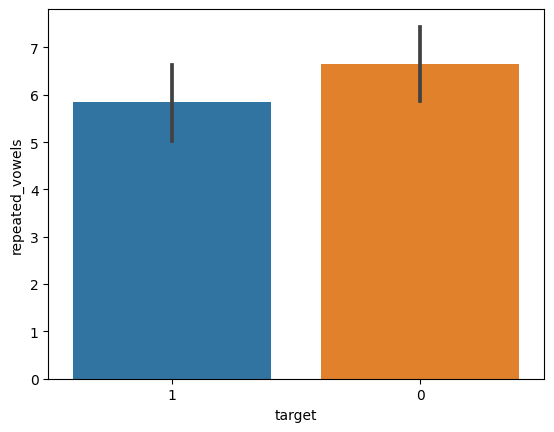

In [26]:
sns.barplot(x='target', y='repeated_vowels', data=train_df1, estimator=lambda x: sum(x) / len(x) * 100)
plt.show()

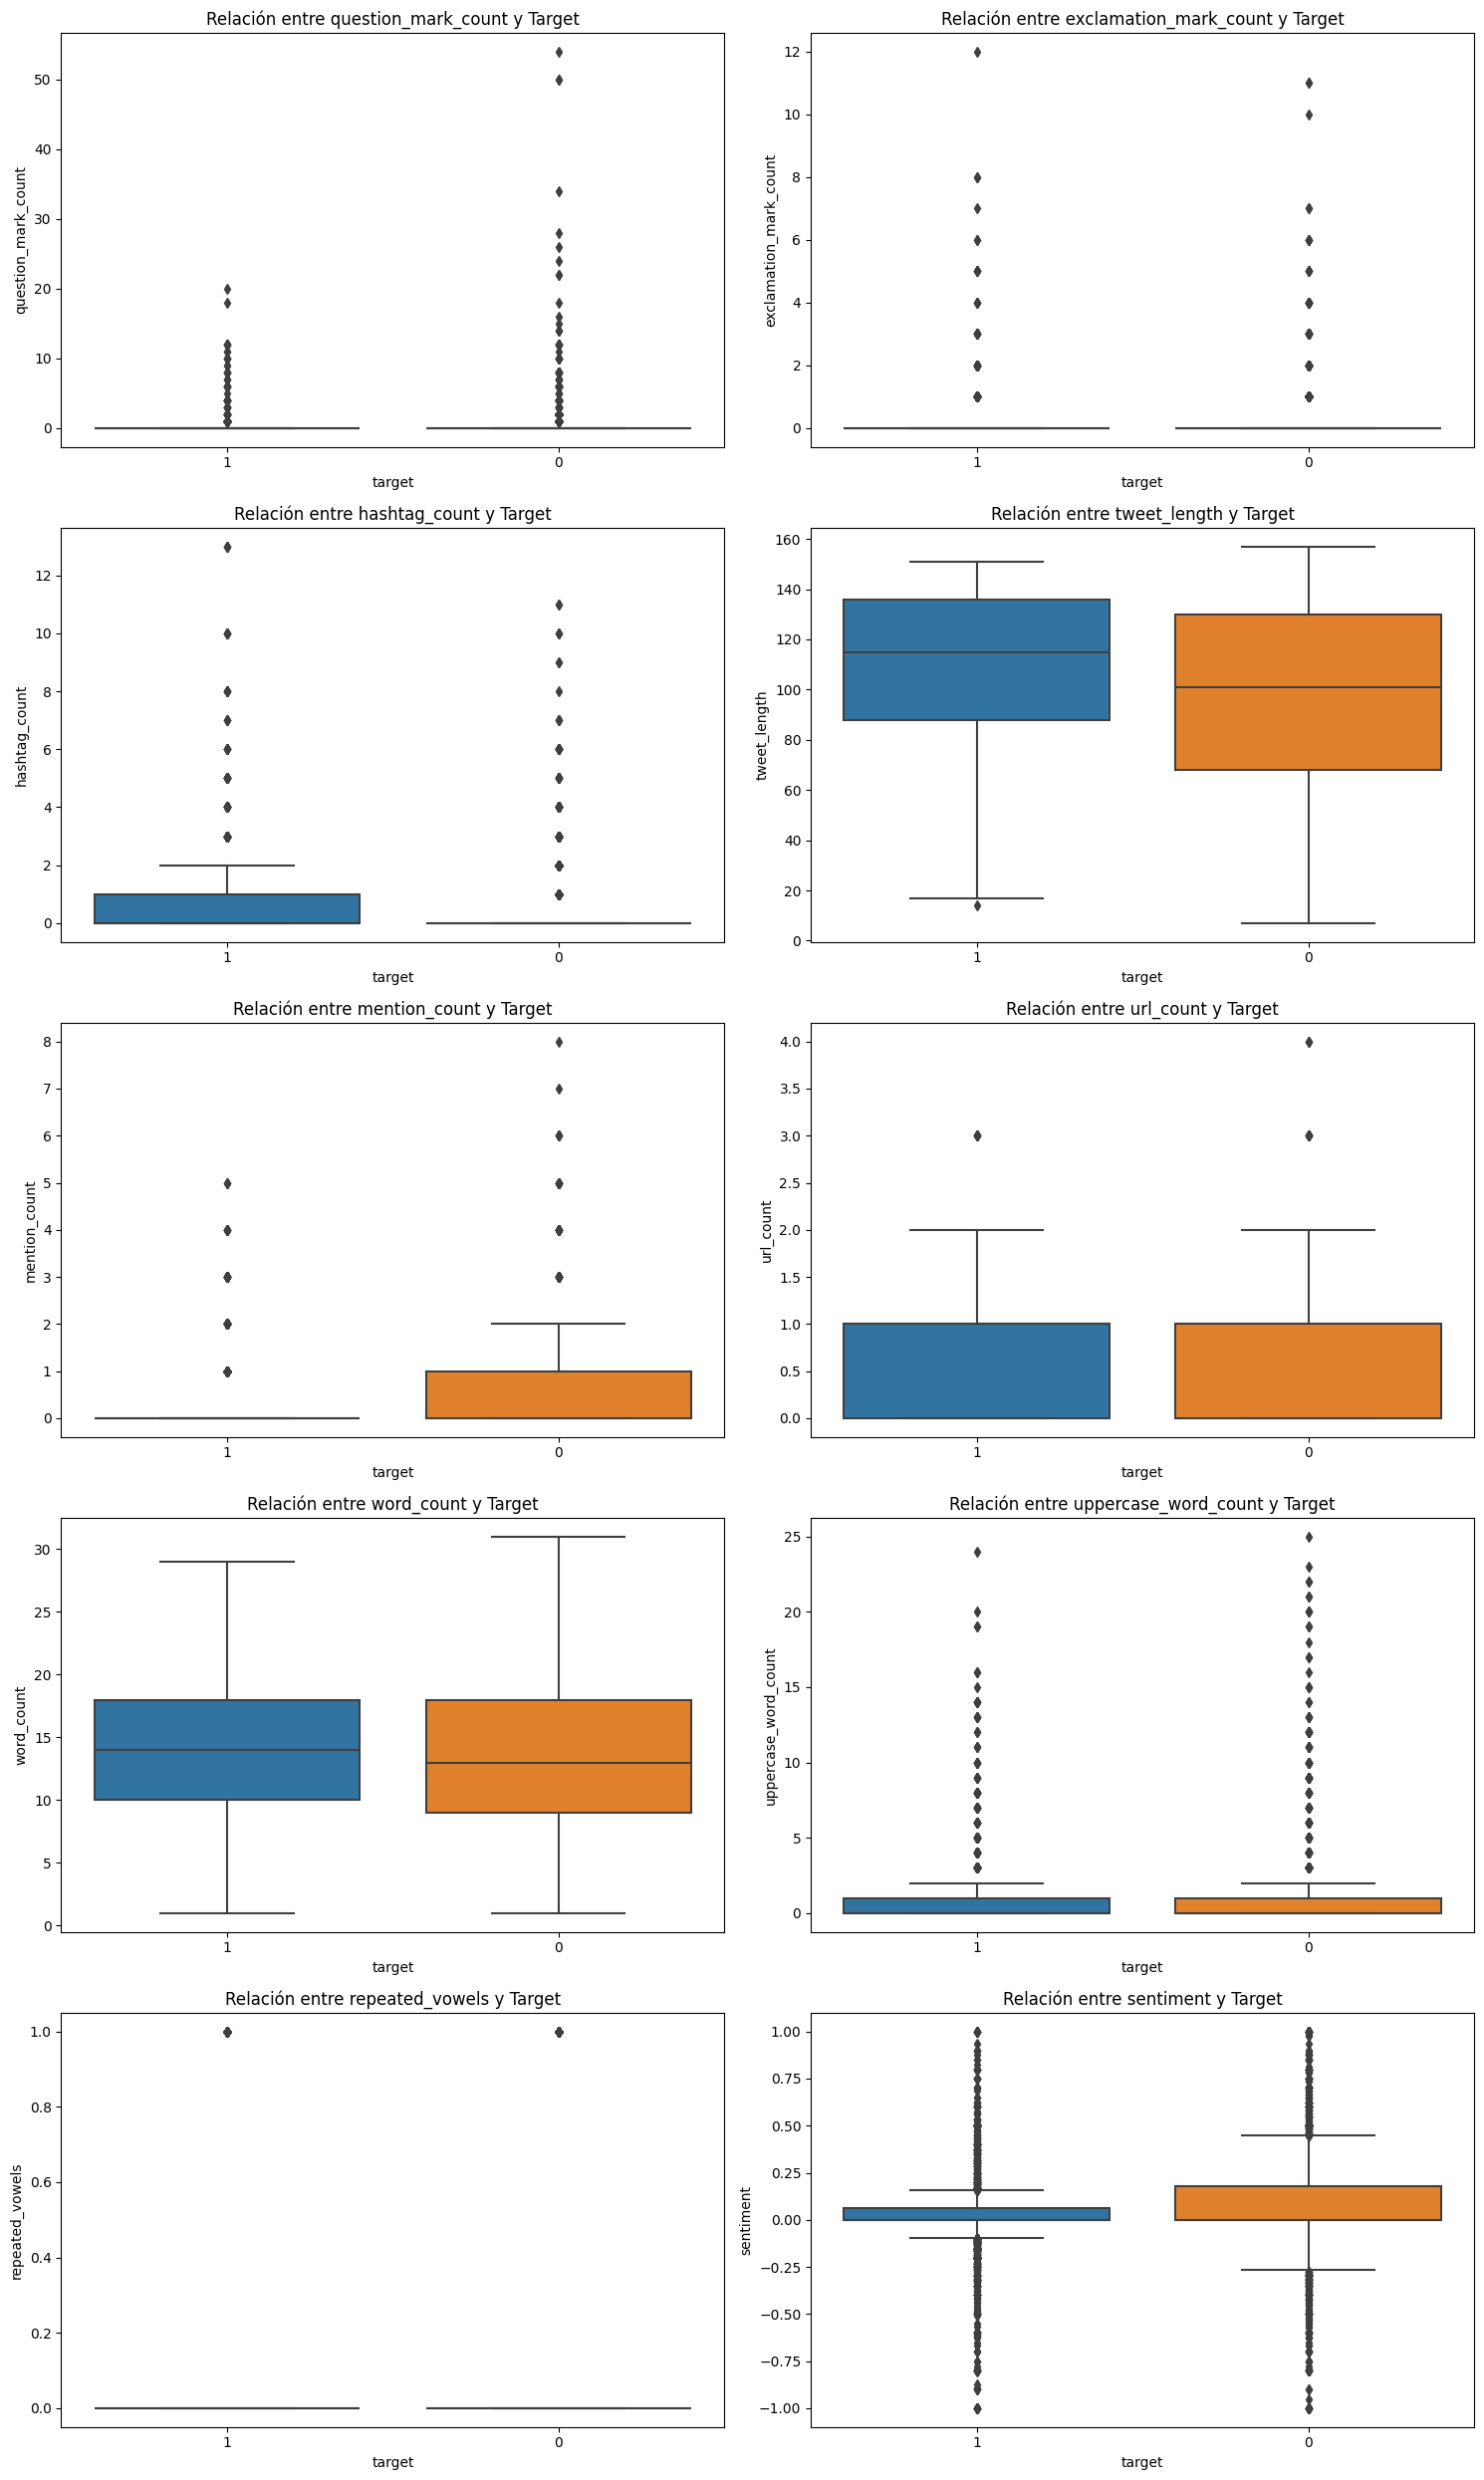

In [27]:
features = ['question_mark_count', 'exclamation_mark_count', 'hashtag_count', 'tweet_length', 'mention_count', 
            'url_count', 'word_count', 'uppercase_word_count', 'repeated_vowels', 'sentiment' ]
n_features = len(features)
n_cols = 2
n_rows = n_features // n_cols + (n_features % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='target', y=feature, data=train_df1)
    plt.title(f'Relación entre {feature} y Target')

plt.tight_layout()
plt.show()

In [28]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7613 non-null   int64  
 1   keyword                 7552 non-null   object 
 2   location                5080 non-null   object 
 3   text                    7613 non-null   object 
 4   target                  7613 non-null   object 
 5   normalized_location     7613 non-null   object 
 6   location_final          7613 non-null   object 
 7   tweet_length            7613 non-null   int64  
 8   clean_text              7613 non-null   object 
 9   words                   7613 non-null   object 
 10  word_count              7613 non-null   int64  
 11  contains_numbers        7613 non-null   int64  
 12  hashtag_count           7613 non-null   int64  
 13  mention_count           7613 non-null   int64  
 14  exclamation_mark_count  7613 non-null   

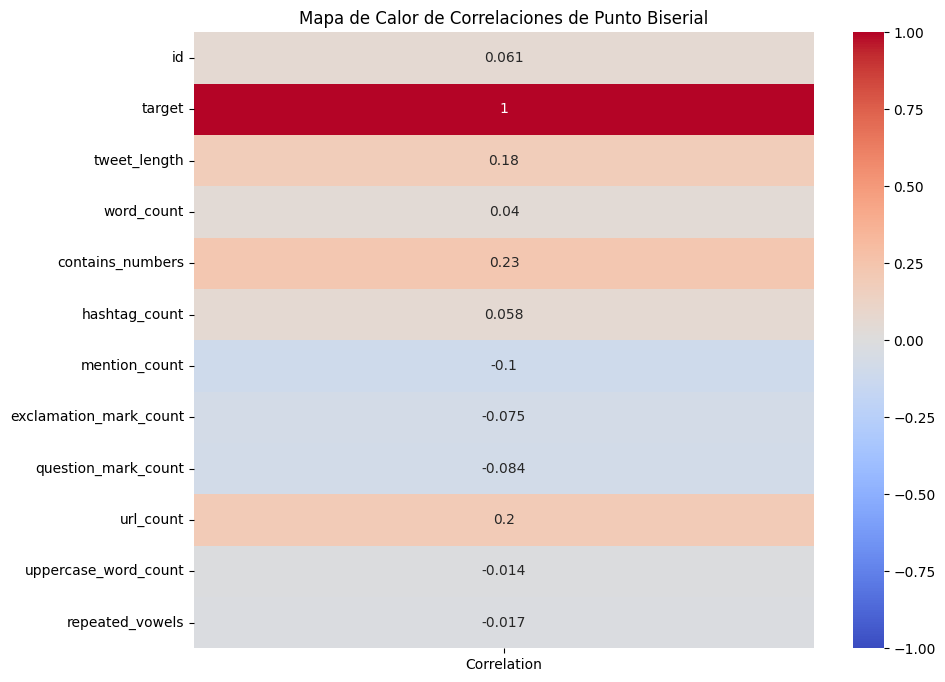

In [34]:

# Asegúrate de que 'target' es numérica y no tiene valores nulos
train_df1['target'] = pd.to_numeric(train_df1['target'], errors='coerce')

# Selecciona las columnas numéricas
numerical_columns = train_df1.select_dtypes(include=['int64']).columns

# Crear un DataFrame vacío para almacenar las correlaciones
correlation_matrix = pd.DataFrame(index=numerical_columns, columns=['Correlation'])

# Calcular la correlación de punto biserial para cada columna numérica
for column in numerical_columns:
    # Asegúrate de que la columna no contenga valores no numéricos o nulos
    non_null_numeric = train_df1[column].dropna()
    non_null_numeric = pd.to_numeric(non_null_numeric, errors='coerce').dropna()

    # Calcular la correlación de punto biserial
    correlation, _ = stats.pointbiserialr(non_null_numeric, train_df1['target'].loc[non_null_numeric.index])
    correlation_matrix.loc[column, 'Correlation'] = float(correlation)  # Asegurarse de que el valor es flotante

# Eliminar cualquier fila que tenga NaN en 'Correlation'
correlation_matrix = correlation_matrix.dropna()

# Visualizar con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(train_df1.select_dtypes(include=['int64']).corr(),annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlaciones de Punto Biserial")
plt.show()

In [50]:
correlation_matrix = train_df1.select_dtypes(include=['int64', 'float64']).corr()

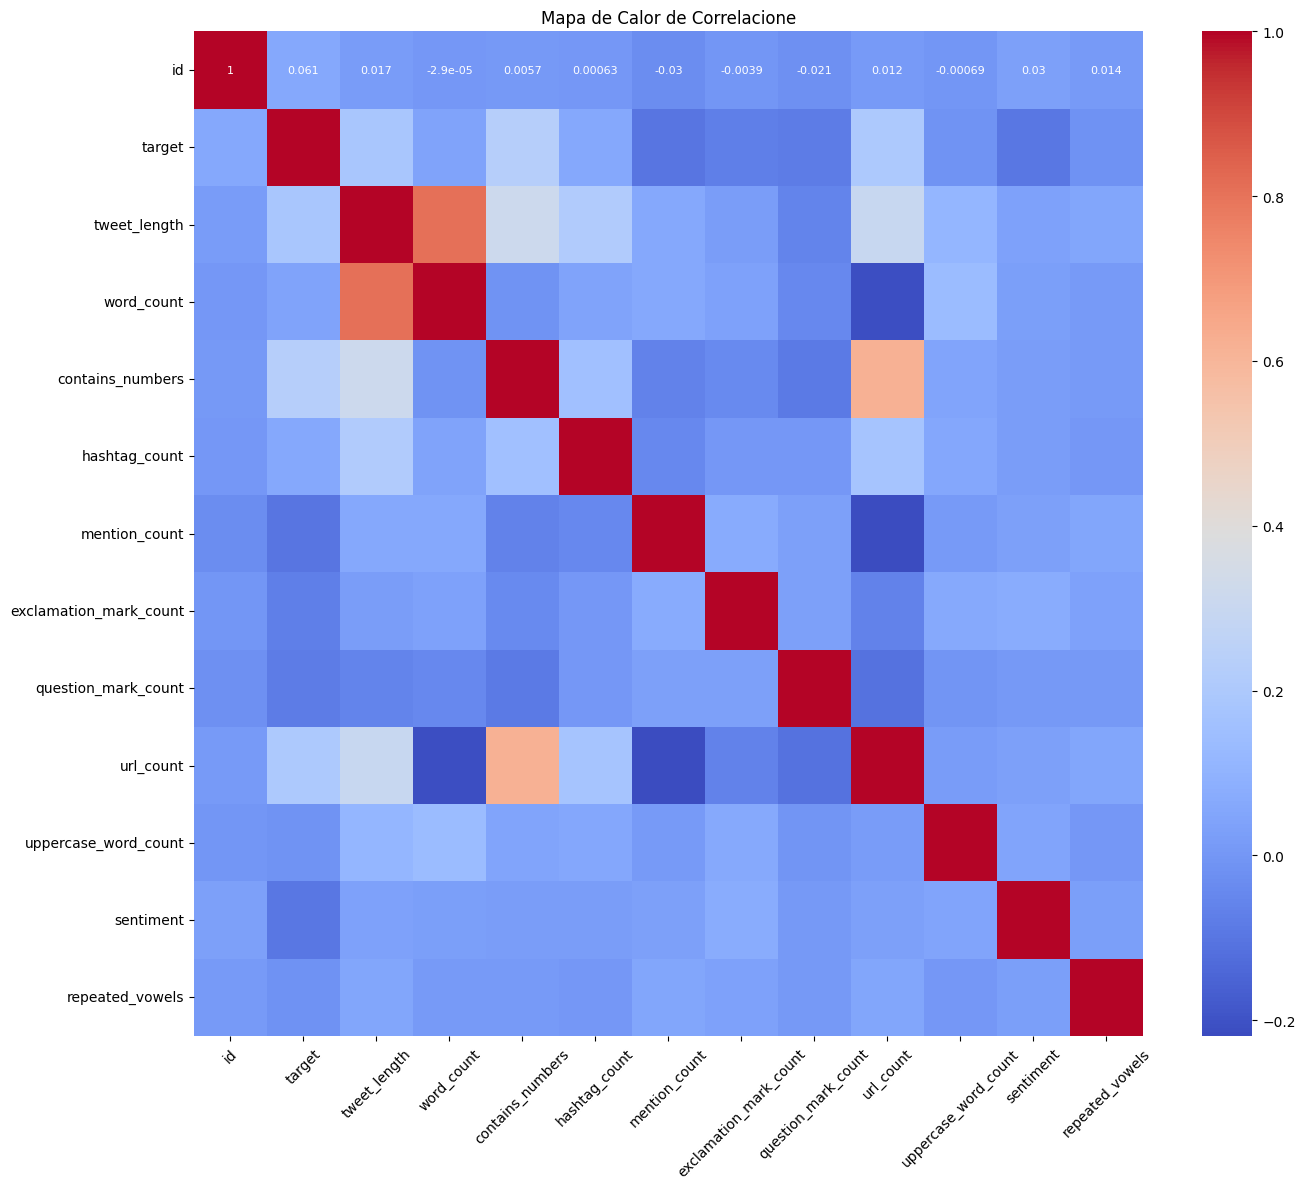

In [51]:
# Visualizar con un mapa de calor
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix,annot=True, cmap="coolwarm", fmt=".2g", annot_kws={"size": 8})
plt.title("Mapa de Calor de Correlacione")
plt.xticks(rotation=45)  # Rota las etiquetas del eje X si es necesario
plt.yticks(rotation=0)  # Rota las etiquetas del eje Y si es necesario
plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama
plt.show()

In [32]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7613 non-null   int64  
 1   keyword                 7552 non-null   object 
 2   location                5080 non-null   object 
 3   text                    7613 non-null   object 
 4   target                  7613 non-null   int64  
 5   normalized_location     7613 non-null   object 
 6   location_final          7613 non-null   object 
 7   tweet_length            7613 non-null   int64  
 8   clean_text              7613 non-null   object 
 9   words                   7613 non-null   object 
 10  word_count              7613 non-null   int64  
 11  contains_numbers        7613 non-null   int64  
 12  hashtag_count           7613 non-null   int64  
 13  mention_count           7613 non-null   int64  
 14  exclamation_mark_count  7613 non-null   